# Important Notes XGBoost

In [131]:
import pandas as pd 
import numpy  as np
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10

In [132]:
dataset = pd.read_csv(r"C:\Users\saughosh\Desktop\IMS\Course\DS3\6.Machine Learning\Algo\Classfication\Tree\Xboost\Model\Dataset\Model_Dataset\train.csv")
predictors = [d for d in dataset.columns if d not in ["Disbursed"]]
x_train, x_test, y_train,y_test = train_test_split(dataset[predictors], dataset["Disbursed"], test_size = .3 , random_state = 42)

###convert into xgb format 
d_train = xgb.DMatrix(x_train, label = y_train)
d_test  = xgb.DMatrix(x_test, label = y_test)

In [133]:
def prob_score(y_act,y_pred):
    model_metrics = []
    prb_range = np.linspace(0,1,100,endpoint=False)
    for p in prb_range:
        pred = y_pred > round(p,2)
        confusion_metrics =  metrics.confusion_matrix(y_act,pred)
        accuracy = metrics.accuracy_score(y_act,pred)
        precission = metrics.precision_score(y_act,pred)
        specitivity = confusion_metrics[0,0]/(confusion_metrics[0,0] + confusion_metrics[0,1])
        sensitivity = confusion_metrics[1,1]/(confusion_metrics[1,1] + confusion_metrics[1,0])
        f1 = metrics.f1_score(y_act,pred)
        base = np.sum(pred == True)
        metric = np.array([p,accuracy,precission,sensitivity,specitivity,f1,base])
        model_metrics.append(metric)

    model_metrics = round(pd.DataFrame(model_metrics),2)
    model_metrics.columns = [["Probablity","Accuracy","Precission","Sensitivity","Specificity","f1","Base"]]
    return model_metrics

In [134]:
def auc_score(y_act,y_pred):
    auc_score = metrics.roc_auc_score(y_act,y_pred)
    return auc_score


In [135]:
def lift_score(dataset, pred , y):
    dataset["Pred_Prob"] = pred
    dataset["Target"] = y
    dataset = dataset.sort_values(by = "Pred_Prob" , ascending = False)
    dataset["Decile"] = pd.qcut(dataset["Pred_Prob"],10, labels = False)
    lift_data  =  pd.DataFrame(dataset["Decile"].value_counts())
    lift_data  =  lift_data.sort_index(ascending = False)
    pos_label  =  pd.DataFrame(dataset[["Target","Decile"]][dataset["Target"] == 1].groupby("Decile").count())
    neg_label  =  pd.DataFrame(dataset[["Target","Decile"]][dataset["Target"] == 0].groupby("Decile").count())
    lift_data  = pd.merge(lift_data , pos_label , how = "left" , left_index = True , right_index = True)
    lift_data  = pd.merge(lift_data , neg_label , how = "left" , left_index = True , right_index = True)
    lift_data.columns =[["Events","Pos_Events","Neg_Events"]]
    lift_data = lift_data.fillna(0)
    
    lift_data["Pos_Event%"]     = lift_data["Pos_Events"]/float(lift_data["Pos_Events"].sum())
    lift_data["Neg_Event%"]     = lift_data["Neg_Events"]/float(lift_data["Neg_Events"].sum())
    lift_data["Event%"]         = round(lift_data["Events"]/float(lift_data["Events"].sum()),2)
    lift_data["Cum_Pos_Event"]  = lift_data["Pos_Event%"].cumsum()
    lift_data["Cum_Neg_Event"]  = lift_data["Neg_Event%"].cumsum()
    lift_data["Cum_Event"]      = lift_data["Event%"].cumsum()
    lift_data["Cumm_Lift"]      = lift_data["Cum_Pos_Event"].values/lift_data["Cum_Event"].values
    lift_data["KS_Stats"]       = lift_data["Cum_Pos_Event"].values - lift_data["Cum_Neg_Event"].values
    
    return lift_data

In [136]:
def xbg_model(params,d_train,d_test ,num_rounds):

    watchlist  = [(d_test,"test"),(d_train,"train")]
    xgb_model = xgb.train(params , d_train, num_rounds, watchlist )
    feature_importance =  pd.DataFrame(list(xgb_model.get_fscore().values()) , index = list(xgb_model.get_fscore().keys()) ,columns= ["Score"])
    feature_importance = feature_importance.sort_values(by ="Score", ascending= False)
    feature_importance.plot(kind  = "barh")
    plt.show()
    y_train_predict = xgb_model.predict(d_train)
    train_auc_score = auc_score(y_train,y_train_predict)
    print("Train_AUC_Score",train_auc_score)
    model_metrics_train = prob_score(y_train,y_train_predict)
    train_lift_data = lift_score(x_train,y_train_predict,y_train)
    
    y_test_predict = xgb_model.predict(d_test)
    test_auc_score =  auc_score(y_test,y_test_predict)
    print("Test_AUC_Score",test_auc_score)
    model_metrics_test = prob_score(y_test,y_test_predict)
    test_lift_data = lift_score(x_test,y_test_predict,y_test)
     
    return model_metrics_train,model_metrics_test ,train_lift_data,test_lift_data

# XGB_Model : Using XGBoost Native Features

[0]	test-error:0.015092	train-error:0.01443
[1]	test-error:0.015092	train-error:0.01443
[2]	test-error:0.015092	train-error:0.01443
[3]	test-error:0.015092	train-error:0.01443
[4]	test-error:0.015092	train-error:0.01443
[5]	test-error:0.015092	train-error:0.01443
[6]	test-error:0.015092	train-error:0.01443
[7]	test-error:0.015092	train-error:0.01443
[8]	test-error:0.015092	train-error:0.01443
[9]	test-error:0.015092	train-error:0.01443
[10]	test-error:0.015092	train-error:0.01443
[11]	test-error:0.015092	train-error:0.01443
[12]	test-error:0.015092	train-error:0.01443
[13]	test-error:0.015092	train-error:0.01443
[14]	test-error:0.015092	train-error:0.01443
[15]	test-error:0.015092	train-error:0.01443
[16]	test-error:0.015092	train-error:0.01443
[17]	test-error:0.015092	train-error:0.01443
[18]	test-error:0.015092	train-error:0.01443
[19]	test-error:0.015092	train-error:0.01443
[20]	test-error:0.015092	train-error:0.01443
[21]	test-error:0.015092	train-error:0.01443
[22]	test-error:0.01

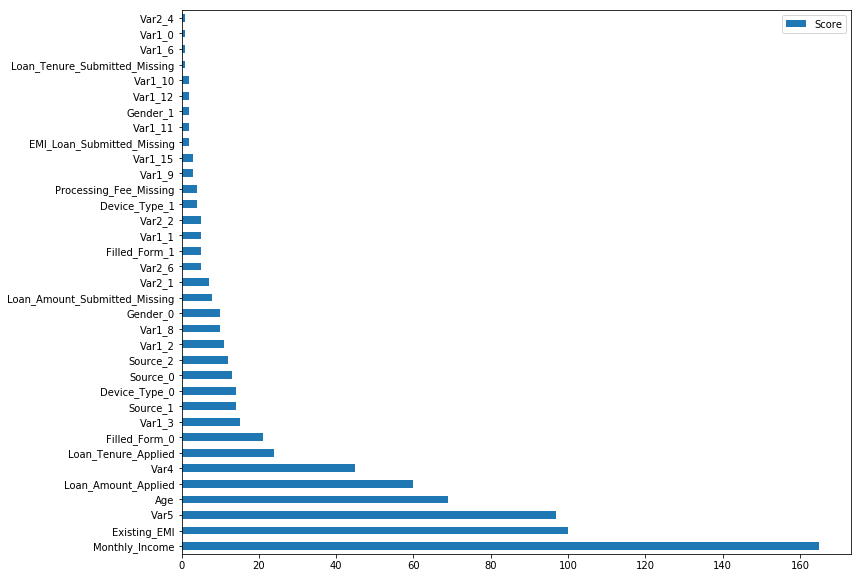

Train_AUC_Score 0.8716302862010812
Test_AUC_Score 0.8276297642136718


In [137]:
params = {
        'learning_rate' : 0.1,
        'n_estimators' : 1000,
        'max_depth' : 4,
        'min_child_weight': 4,
        'gamma' : 2,
        'lambda' : 3,
        'subsample' : 0.8,
        'colsample_bytree' : 0.8,
        'objective' : 'binary:logistic',
        'nthread' :4,
        'silent' : 1,
        'eval_metrics' : 'auc',
        'seed' : 27}
num_rounds = 100

train_labels = d_train.get_label()
ratio = np.float(np.sum(train_labels == 0)/np.sum(train_labels == 1))
params["scale_pos_weight"] = 1
#weights = np.zeros(len(y_train))
#weights[y_train == 0] = 1
#weights[y_train == 1] = 9
#d_train = xgb.DMatrix(x_train, label = y_train, weight = weights)

model_metrics_train,model_metrics_test ,train_lift_data,test_lift_data = xbg_model(params,d_train,d_test,num_rounds)

# XGB_Model : Using XGBoost  + Sklearn

In [138]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [145]:
def modelfit(alg, x_train, x_test, y_train,y_test, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train[predictors], label = y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train[predictors], y_train,eval_metric='auc')
        
    #Predict training set:
#   dtrain_predictions = alg.predict(x_train[predictors])
    dtrain_predprob = alg.predict_proba(x_train[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    train_auc_score         = auc_score(y_train,dtrain_predprob)
    model_metrics_train     = prob_score(y_train,dtrain_predprob)
    train_lift_data         = lift_score(x_train,dtrain_predprob,y_train)
    print ("AUC Score (Train): %f" % train_auc_score)
    
#     Predict on testing data:
#    dtest_predictions = alg.predict(x_test[predictors])
    dtest_predprob = alg.predict_proba(x_test[predictors])[:,1]
    test_auc_score       = auc_score(y_test,dtest_predprob)
    model_metrics_test   = prob_score(y_test,dtest_predprob)
    test_lift_data       = lift_score(x_test,dtest_predprob,y_test)
    print ('AUC Score (Test): %f' % test_auc_score)
                
    feat_imp = pd.DataFrame(alg.feature_importances_)
    feat_imp.index = predictors
    feat_imp.columns = ["Score"]
    feat_imp = feat_imp.sort_values(by = "Score", ascending = False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model_metrics_train,train_lift_data,model_metrics_test,test_lift_data,alg

# Base Model


Model Report
AUC Score (Train): 0.901938
AUC Score (Test): 0.828125


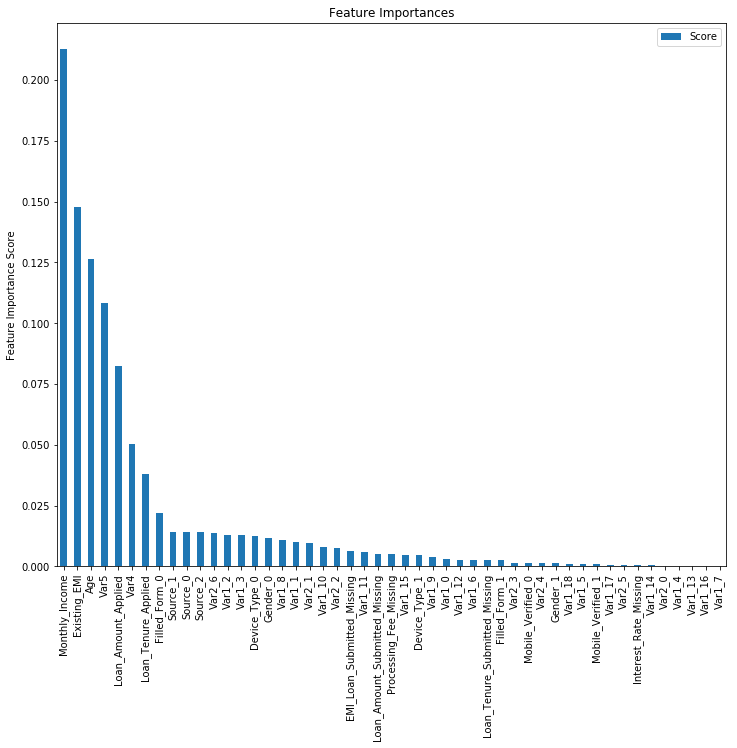

In [146]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

model_metrics_train,train_lift_data,model_metrics_test,test_lift_data,alg = modelfit(xgb1, x_train, x_test, y_train,y_test, predictors)


In [149]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':np.arange(3,10,2),
    'min_child_weight': np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': array([3, 5, 7, 9]), 'min_child_weight': array([1, 3, 5])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [151]:
gsearch1.grid_scores_ , gsearch1.best_params_, gsearch1.best_score_

([mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [153]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [154]:
gsearch1.grid_scores_ , gsearch1.best_params_, gsearch1.best_score_

([mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [157]:
range(len(x_train[0]))

KeyError: 0